# Document Clustering and Topic Modeling on Google Colab
## Author: Ben (www.linkedin.com/in/ben-usc)

### In this project, I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

### data source: https://www.kaggle.com/jrobischon/wikipedia-movie-plots

## Contents:
###Part-1: Load-Data
###Part-2: Tokenizing-and-Stemming
###Part 3: TF-IDF vectorizer
###Part 4: K-means clustering
###Part 5: Topic Modeling - Latent Dirichlet Allocation

# Part 0: Setup Google Drive Environment

In [1]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 5.1MB/s 


In [0]:
## google drive link for wiki_movie_plots_deduped.csv:
## https://drive.google.com/open?id=1vCnBPFe2-fS9SearAlG6NZAu-_ku01Ld

## create google drive file:
file1 = drive.CreateFile({'id': '1vCnBPFe2-fS9SearAlG6NZAu-_ku01Ld'}) # replace the id with id of file you want to access
file1.GetContentFile('wiki_movie_plots_deduped.csv')

# Part 1: Load and explore data

## the CSV movi info file contains: Release Year, Title, Origin/Ethnicity ,Director, Cast, Genre, Wiki Page, Plot

In [3]:
## load packages and libraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
# REGULAR EXPRESSION
import re
import os

## CSV file
import csv

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
## define function to read the file and convert to list
def readCSV(file, cols):
    res = tuple([] for i in range(len(cols)))
    with open(file, 'r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are: {", ".join(row)}')
            line_count += 1
            for i in range(len(cols)):
                res[i].append(row[cols[i]])
    print(f'Processed {line_count} lines.')
    return res
  
years, titles, origins, directors, casts, genres, synopses = readCSV("wiki_movie_plots_deduped.csv",\
                                                                     ["Release Year", "Title", "Origin/Ethnicity", "Director", "Cast", "Genre", "Plot"])

Column names are: Release Year, Title, Origin/Ethnicity, Director, Cast, Genre, Wiki Page, Plot
Processed 34886 lines.


In [0]:
## update years and genres:
years = [int(s) for s in years]

## update strings:
def removeSpace(string):
    tmp = string
    if len(string) <2: return ""
    if(string[0]== " "):
        tmp = string[1:]
    if(tmp[-1] == " "):
        tmp = tmp[0:-1]
    return tmp
## update generes:
def updateGenres(genres):
    new_genres = []
    for s in genres:
        tp = removeSpace(s.replace("/",","))
        new_genres.append(tp)
    return new_genres

genres = updateGenres(genres)

## check the distribution of movie release years,  movie synopsis length, and the movie origins:

In [0]:
## create data test distributions of movie release year, length of synopsis, and movie origin:
snps_length = np.asarray([len(s) for s in synopses])
test_data = {"year":years, "length":snps_length, "origin": origins}
test_df = pd.DataFrame(test_data, columns = ["year", "length", "origin"])

Text(0.5, 1.0, 'Movie release year')

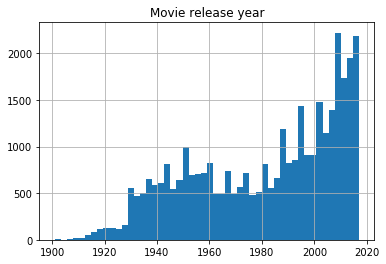

In [7]:
## check the distribution of movie release year:
test_df.hist(column='year', bins=50)
plt.title('Movie release year')

how many synopses longer 2000?: 15405


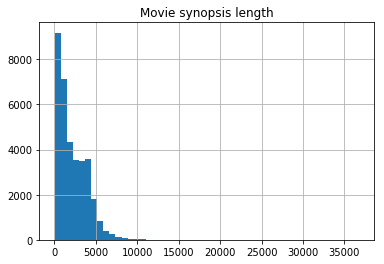

In [8]:
## test distributions of synopsis length:
test_df.hist(column="length",bins=50)
plt.title("Movie synopsis length")
longer = [1 if len(s)>=2000 else 0 for s in synopses]
print(f"how many synopses longer 2000?: {sum(longer)}")

Text(0.5, 1.0, 'Movie origin')

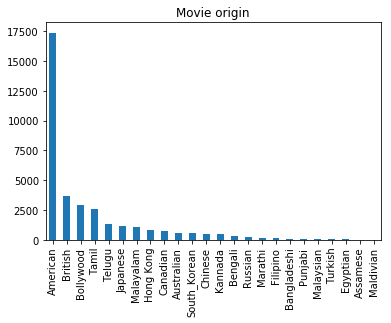

In [9]:
## test distributions of movie origin:
test_df.origin.value_counts().plot(kind='bar')
plt.title("Movie origin")

In [0]:
## select movies satisfying the following conditions:
## condition 1: synopses longer than 2000
## condition 2: origin American
## condition 3: no earlier than 1991 (the year I was born)
cond1, cond2, cond3 = [], [], []
for i in range(len(years)):
    if len(synopses[i])>=2000:
        cond1.append(i)
    if origins[i] == "American":
        cond2.append(i)
    if years[i] > 1990:
        cond3.append(i)
cond12 = set(cond1).intersection(set(cond2))
cond = sorted(list(cond12.intersection(set(cond3))))

## pick up filtered data
years = [ years[i] for i in cond ]
titles = [ titles[i] for i in cond ]
directors = [ directors[i] for i in cond]
casts = [ casts[i] for i in cond]
genres = [ genres[i] for i in cond ]
synopses = [ synopses[i] for i in cond ]

In [0]:
# create DataFrame movies:
movies = { 'year': years,'title':titles, 'director':directors,
          'cast':casts, 'genre':genres,'synopsis':synopses }
movieDF = pd.DataFrame(movies, columns = ['year', 'title','director','cast','genre','synopsis'])
#movieDF = movieDF.reset_index(drop=True)

## generate a list of ordered numbers for indexing.
indices = range(movieDF.count()[0])
movieDF['index'] = indices

# Part 2: Tokenizing and Stemming

###Load stopwords and stemmer function from NLTK library.
###Stop words are words like "a", "the", or "in" which don't convey significant meaning.
###Stemming is the process of breaking a word down into its root.

In [23]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

stopwords.extend(list(set(["frank","joe","jimmy","john","mary","sarah","connor","ted","freddy","kate",\
                           "jack","greg","rose","elizabeth","max","donna","ben","anna",\
                           "jim","james","steve","charlie","scott","david","michael","sam","nick","paul"])))
stopwords.extend(["kill","killed","killing", "kills"] )
stopwords.extend(["'s", "n't", "'ll"])
stopwords.extend(["find","finds","finding","found","make","makes","made","making","use","using",
                  "get","gets","getting","got", "tells","told","telling", "taking", "takes", "take","took","taken"])
stopword_set = set(stopwords)

print ("We use " + str(len(set(stopwords))) + " stop-words from nltk library.")

We use 236 stop-words from nltk library.


In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    # exclude stop words and tokenize the document, generate a list of string 
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopword_set]

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# tokenization without stemming
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopword_set]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# tokenization and stemming test:
tokenization_and_stemming("she looked at her father's arms.\n")

['look', 'father', 'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [25]:
# 1. do tokenization and stemming for all the documents
# 2. do tokenization for all the documents
# 3. create a mapping from stemmed words to original tokenized words for result interpretation.
stemmed = []
tokenized = []
## convert plots to list:
plots = [i for i in movieDF['synopsis']]
for i in plots:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    tokenized.extend(tokenized_results)

### --------------------------
stem_token_dict = {stemmed[i]:tokenized[i] for i in range(len(stemmed))}
print (stem_token_dict['warn'])

warns


# Part 3: TF-IDF: Term Frequency - Inverse Document Frequency

In [26]:
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram

tfidf_model = TfidfVectorizer(max_df = 0.8, min_df = 0.1, max_features = 2000,
                              stop_words = stopwords, ngram_range = (1,1), use_idf = True, 
                              tokenizer = tokenization_and_stemming)

tfidf_matrix = tfidf_model.fit_transform(movieDF['synopsis']) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synopses and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 4426 synopses and 478 terms.


##Save the parameters and terms identified by TF-IDF.

In [0]:
# check the tfidf_model parameters:
tfidf_params = tfidf_model.get_params()

# check the tfidf_model words:
tf_selected_words = tfidf_model.get_feature_names()
#print(tf_selected_words)

##Calculate Document Similarity

similarity matrix dimension: (100, 100)
similarity matrix for most recent 100 movies from the year 2017:


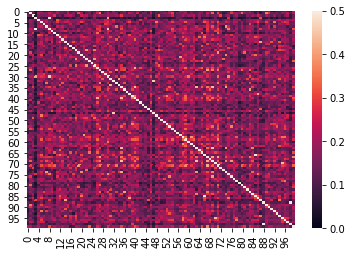

In [28]:
# use cosine similarity to check the similarity for two documents
from sklearn.metrics.pairwise import cosine_similarity

## sample the most recent 100 movies for computing similarity:
idstart = tfidf_matrix.shape[0] - 100
sample = tfidf_matrix[idstart:]

cos_matrix = cosine_similarity(sample)
print(f"similarity matrix dimension: {cos_matrix.shape}")
print(f"similarity matrix for most recent 100 movies from the year {movieDF['year'][idstart]}:")

#%matplotlib inline
import seaborn as sns
ax = sns.heatmap(cos_matrix, vmin=0, vmax=0.5)
plt.show()

# Part 4: K-means clustering

In [0]:
# k-means clustering
from sklearn.cluster import KMeans

# number of clusters
num_clusters = 5
km = KMeans(n_clusters = num_clusters, random_state=17)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()


### add cluster info to movieDF
movieDF['cluster'] = clusters

## 4.1. Analyze K-means Result

In [30]:
print ("Number of films included in each cluster:")
cluster_counts = movieDF['cluster'].value_counts().to_frame()
print(cluster_counts)

Number of films included in each cluster:
   cluster
2     1174
4     1129
1     1010
0      932
3      181


In [31]:
n_word = 8

print (f"<Document clustering result by K-means>: first {n_word} words for each cluster")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
centers = km.cluster_centers_.argsort()[:, ::-1] 
cluster_keywords = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words: ", end='')
    cluster_keywords[i] = []
    for ind in centers[i, :n_word]: #replace with words per cluster
        cluster_keywords[i].append(stem_token_dict[tf_selected_words[ind]])
        print (stem_token_dict[tf_selected_words[ind]] + ",", end='')
    print ()
    #i is the clusterID:
    #query_i = "cluster == "+str(i)
    #cluster_movies = movieDF.query(query_i)['title'].values.tolist()
    #print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    #print (", ".join(cluster_movies))
    #print ()

<Document clustering result by K-means>: first 8 words for each cluster
Cluster 0 words: family,father,mother,house,home,children,son,leave,
Cluster 1 words: police,car,murdering,shoots,money,gun,house,drugs,
Cluster 2 words: escape,attacked,group,human,destroy,power,fight,returned,
Cluster 3 words: team,games,played,win,school,first,new,back,
Cluster 4 words: school,friends,love,leave,new,go,asks,shows,


## 4.2. Plot K-means Result

In [33]:
# use pca to reduce dimensions to 2d for visibility, just want to see if there 2d can give us some insights
# this is not an appropriate method, just a guess.
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np = tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)
print("Shape of PCA transformed tfidf matrix: ", X.shape)

xs, ys = X[:, 0], X[:, 1]

#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ",".join(cluster_keywords[i])

Shape of PCA transformed tfidf matrix:  (4426, 2)


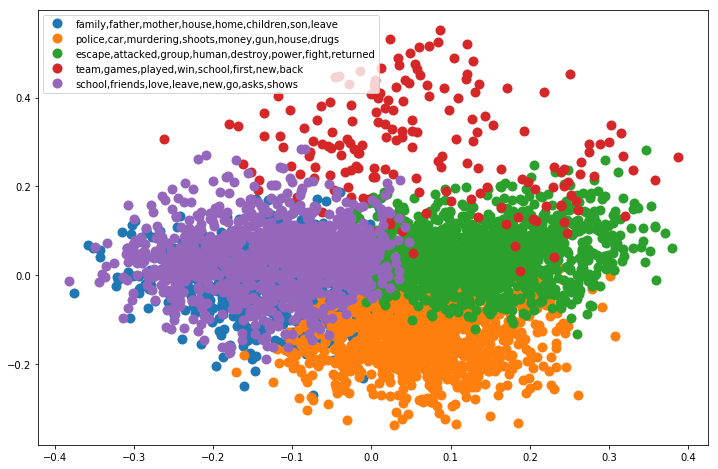

In [34]:
# %matplotlib inline 
#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=movieDF['cluster'], title=movieDF['title'])) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(12, 8))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, 
            label=cluster_names[name], mec='none')

ax.legend(numpoints=1,loc='best')  #show legend with only 1 point, position is right bottom.
plt.show() #show the plot

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [0]:
# Use LDA for clustering
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = num_clusters, learning_method = 'online', random_state=0)

In [36]:
# LDA requires integer values, keep first 2 digits
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

lda.fit(tfidf_matrix_lda)

## topic score for each of the 4000+ document:
doc_topic = lda.transform(tfidf_matrix_lda)
print("Shape of doc_topic matrix: ", doc_topic.shape)

Shape of doc_topic matrix:  (4426, 5)


In [37]:
# topics and feature matrix
topic_word = lda.components_
print("Shape of topic word matrix: ", topic_word.shape)

Shape of topic word matrix:  (5, 478)


In [38]:
## find the cluster id for each document
lda_clusters = [ l.argmax() for l in doc_topic ]

## put this information to movieDF:
movieDF['lda_cluster'] = lda_clusters

## count how many movies for each cluster:
print ("Number of movies included in each LDA cluster:")
cluster_counts = movieDF['lda_cluster'].value_counts().to_frame()
print(cluster_counts)

Number of movies included in each LDA cluster:
   lda_cluster
4         1207
2         1031
3          982
0          715
1          491


In [0]:
n_top_words = 8
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = stem_token_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [40]:
# print out the clusters and topics and titles of the movies
topic_doc_dict = {}
print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])

## create list for ordered output:
lda_results = []
for i in topic_doc_dict:
    lda_results.append([i, ", ".join(topic_keywords_list[i])])
    #print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    #print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    #print (', '.join(topic_doc_dict[i]))

## ordered output:
lda_results = sorted(lda_results, key = lambda s: s[0])
for res in lda_results:
    print("Cluster " + str(res[0]) + " words: " + res[1])


<Document clustering result by LDA>
Cluster 0 words: family, father, mother, children, son, home, baby
Cluster 1 words: school, games, students, girl, team, win, played
Cluster 2 words: love, relationship, new, shows, work, meets, friends
Cluster 3 words: police, murdering, car, shoots, drugs, money, office
Cluster 4 words: escape, attacked, group, destroy, human, captured, power


In [41]:
## use pca on doc_topic matrix for visualization:
lda_pca = decomposition.PCA(n_components=2)
lda_tfidf_matrix = doc_topic
lda_X = pca.fit_transform(lda_tfidf_matrix)

print("Shape of PCA transformed tfidf matrix: ", lda_X.shape)

lda_cluster_names = {}
for i in range(num_clusters):
    lda_cluster_names[i] = "".join(lda_results[i][1].strip(",").split())

Shape of PCA transformed tfidf matrix:  (4426, 2)


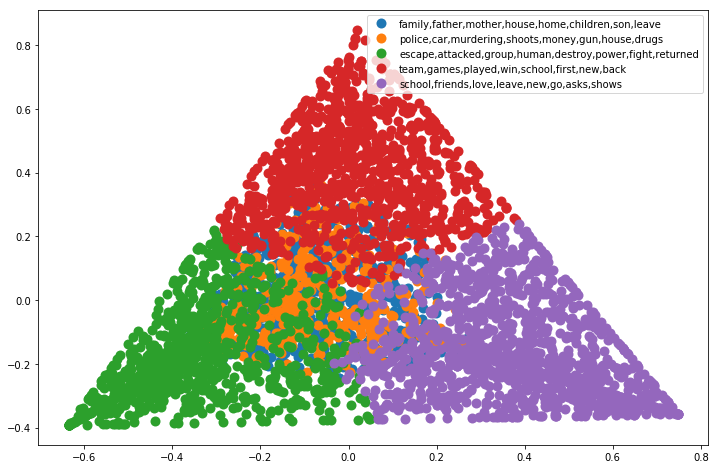

In [42]:
# %matplotlib inline 
#create data frame with lda cluster results

xs, ys = lda_X[:, 0], lda_X[:, 1]

df = pd.DataFrame(dict(x=xs, y=ys, label=movieDF['lda_cluster'])) 
groups = df.groupby(lda_clusters)

# set up plot
fig, ax = plt.subplots(figsize=(12, 8))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, 
            label=cluster_names[name], mec='none')

ax.legend(numpoints=1,loc='best')  #show legend with only 1 point, position is right bottom.
plt.show() #show the plot